In [ ]:
import math
import scipy
from scipy.special import expi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

#-------------------------------------------------------------------#
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#-------------------------------------------------------------------#


Mounted at /content/drive


In [ ]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks')
import gilvan as g

In [ ]:
def find_fronts(t,q,B,Sor,Si):
    end=len(t)-1
    rf=[]
    for i in range(0,end+1):
        if i==0:
            f=np.sqrt(rw*rw+(q[end-i]*B[end-i]*t[end-i]*30)/(np.pi*por*h*(1-Si[end-i]-Sor[end-i])))
        else:
            f=np.sqrt(rf[i-1]*rf[i-1]+(q[end-i]*B[end-i]*t[end-i]*30)/(np.pi*por*h*(1-Si[end-i]-Sor[end-i])))
        rf.append(f) 
    return rf    

def bu_time_vector(t_iw):
    tbu=[]
    tbu.append(0.001)
    while tbu[-1]<=t_iw:
        tbu.append(tbu[-1]*1.123)
    tbu=np.array(tbu)
    return tbu    # in hours

def FeitosaDerivative(rd,td,mob):
    i=0
    derFeit=np.ones(len(td))
    for eachTime in td:
        derFeit[i]=g.Integral(rd , eachTime , mob)
        i=i+1
    return derFeit

def mob_field(rf,ri,mob,mob_ow):
    end=len(rf)
    m=np.ones(len(ri))
    ind=np.arange(end)
    ind_max=end-1
    
    if end==1:
        m[np.where((ri>=rf[0]))]=mob_ow
        m[np.where(ri<rf[0])]=mob[0]
    else:
        for i in ind:
            if i==0:
                m[np.where((ri>rf[i])&(ri<rf[i+1]))]=mob[-2]
                m[np.where((ri<=rf[i]))]=mob[-1]  
            elif i==end-1:
                m[np.where((ri>=rf[i]))]=mob_ow
                m[np.where((ri<rf[i])&(ri>rf[i-1]))]=mob[0]
            else:
                m[np.where((ri>rf[i])&(ri<rf[i+1]))]=mob[ind_max-i-1]
                m[np.where((ri<=rf[i])&(ri>rf[i-1]))]=mob[ind_max-i] 
    return m   

def bank_plat(mob,q,B,k,h):
    end=len(mob)
    ind=np.arange(end)
    ind_max=end-1
    plateau=[]

    for i in ind:
        p=0.5*19.03*(1/(k*h))*(1/mob[i])
        plateau.append(p)

    plateau=np.array(plateau)
    return plateau

# Rock and fluid properties

In [ ]:
### WATER ###
krw_swmax=0.77
Bw=1
visc_w=0.35
mob_wo1=krw_swmax/visc_w

### OIL ###
kro_swi=0.998
kro_sgi=0.998

visc_o=0.45
mob_ow=kro_swi/visc_o
mob_og=kro_sgi/visc_o

### GAS ###
krg_sgmax=0.56
Bg=0.002
visc_g=0.075
mob_go1=krg_sgmax/visc_g

### ROCK ###
h=120
por=0.2
k=500

Swi=0.364
Sgi=0
Sor_w=0.23
Sor_g=0.645

ct=0.00019639

### WELL ###
rw=0.108
re=150*20000000
red=re/rw

### NUMERICAL ###
dt=1/100

### ON-OFF###
sup=0 #turn on/off rate-superposition 
steady_state=1

# **Cycle G1**

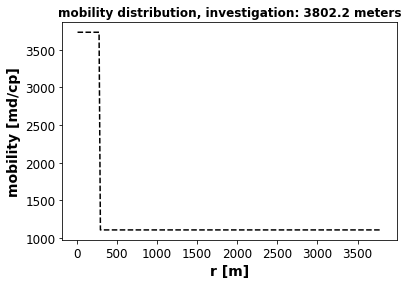

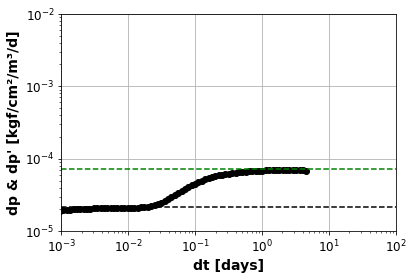

In [ ]:
#cycle properties
cycle=['G1']
B=[Bg]
t=[18.6]
q=[2000000.00]
mob=[mob_go1]
Sor=[Sor_g]
Si=[Sgi]

plateau=bank_plat(mob,q,B,k,h)
o_p=0.5*19.03*(1/(k*h))*(1/mob_ow)

#find fronts
rf=find_fronts(t,q,B,Sor,Si)

# build-up props
tbu=bu_time_vector(100.00) # in hours
tdd=0.0003484*((k*mob[-1])/(por*ct*rw*rw))*tbu
ri=np.sqrt((4*k*mob[-1]*(tbu)*0.0003484)/(por*ct))
rd=ri/rw

# mobility field by the end of the cycles
m=mob_field(rf,ri,mob,mob_ow)
plt.figure()
plt.plot(ri,k*m,'k--')
plt.xlabel("r [m]")
plt.ylabel("mobility [md/cp]")
plt.title(f"mobility distribution, investigation: {round(ri[-1],1)} meters")
plt.savefig('mobfield_g1.png',dpi=200)

# log-log by the end of the cycles
der_Feit=(0.5*19.03*q[-1]*B[-1]/h)*FeitosaDerivative(rd,tdd,k*m)
plt.figure()
plt.loglog(tbu/24,der_Feit/(q[-1]*B[-1]),'ko')
plt.grid()
plt.ylim(0.00001, 0.01)
plt.xlim(0.001, 100)
plt.xlabel("dt [days]")
plt.ylabel("dp & dp' [kgf/cm²/m³/d]")
plt.savefig('loglog_g1.png',dpi=200)

for p in plateau:
        plt.loglog(tbu,np.ones(len(ri))*p,'k--')
        plt.loglog(tbu,np.ones(len(ri))*o_p,'g--')
        
df_t= pd.DataFrame(tbu/24, columns=cycle)
df_der= pd.DataFrame(der_Feit/(q[-1]*B[-1]), columns=cycle)

# **Cycle W1**

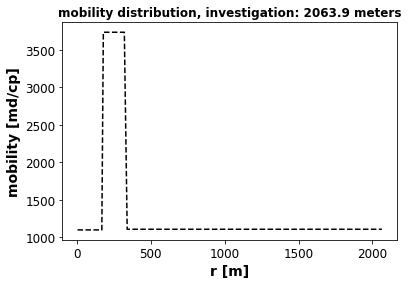

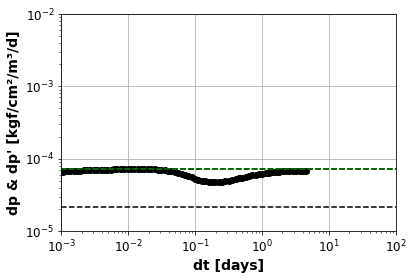

In [ ]:
#cycle properties
cycle=['G1','W1']
B=[Bg,Bw]
t=[18.6,5.5]
q=[2000000.00,5500.00]
mob=[mob_go1,mob_wo1]
Sor=[Sor_g,Sor_w]
Si=[Sgi,Swi]

plateau=bank_plat(mob,q,B,k,h)
o_p=0.5*19.03*(1/(k*h))*(1/mob_ow)

#find fronts
rf=find_fronts(t,q,B,Sor,Si)

# build-up props
tbu=bu_time_vector(100.00) # in hours
tdd=0.0003484*((k*mob[-1])/(por*ct*rw*rw))*tbu
ri=np.sqrt((4*k*mob[-1]*(tbu)*0.0003484)/(por*ct))
rd=ri/rw

# mobility field by the end of the cycles
m=mob_field(rf,ri,mob,mob_ow)
plt.figure()
plt.plot(ri,k*m,'k--')
plt.xlabel("r [m]")
plt.ylabel("mobility [md/cp]")
plt.title(f"mobility distribution, investigation: {round(ri[-1],1)} meters")
plt.savefig('mobfield_w1.png',dpi=200)

# log-log by the end of the cycles
der_Feit=(0.5*19.03*q[-1]*B[-1]/h)*FeitosaDerivative(rd,tdd,k*m)
plt.figure()
plt.loglog(tbu/24,der_Feit/(q[-1]*B[-1]),'ko')
plt.grid()
plt.ylim(0.00001, 0.01)
plt.xlim(0.001, 100)
plt.xlabel("dt [days]")
plt.ylabel("dp & dp' [kgf/cm²/m³/d]")
plt.savefig('loglog_w1.png',dpi=200)

for p in plateau:
        plt.loglog(tbu,np.ones(len(ri))*p,'k--')
        plt.loglog(tbu,np.ones(len(ri))*o_p,'g--')
        
df_t[cycle[-1]]= pd.DataFrame(tbu/24)
df_der[cycle[-1]]= pd.DataFrame(der_Feit/(q[-1]*B[-1]))

# **Cycle G2**

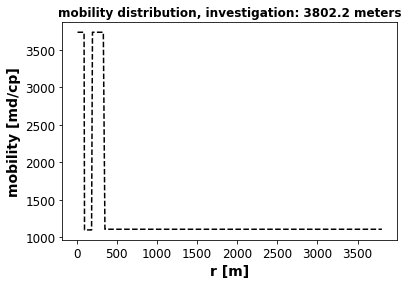

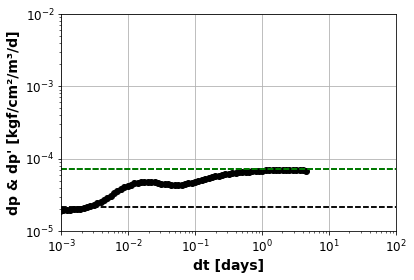

In [ ]:
#cycle properties
cycle=['G1','W1','G2']
B=[Bg,Bw,Bg]
t=[18.6,5.5,4.3]
q=[2000000.00,5500.00,954000.00]
mob=[mob_go1,mob_wo1,mob_go1]
Sor=[Sor_g,Sor_w,Sor_g]
Si=[Sgi,Swi,Sgi]

plateau=bank_plat(mob,q,B,k,h)
o_p=0.5*19.03*(1/(k*h))*(1/mob_ow)

#find fronts
rf=find_fronts(t,q,B,Sor,Si)

# build-up props
tbu=bu_time_vector(100.00) # in hours
tdd=0.0003484*((k*mob[-1])/(por*ct*rw*rw))*tbu
ri=np.sqrt((4*k*mob[-1]*(tbu)*0.0003484)/(por*ct))
rd=ri/rw

# mobility field by the end of the cycles
m=mob_field(rf,ri,mob,mob_ow)
plt.figure()
plt.plot(ri,k*m,'k--')
plt.xlabel("r [m]")
plt.ylabel("mobility [md/cp]")
plt.title(f"mobility distribution, investigation: {round(ri[-1],1)} meters")
plt.savefig('mobfield_g2.png',dpi=200)

# log-log by the end of the cycles
der_Feit=(0.5*19.03*q[-1]*B[-1]/h)*FeitosaDerivative(rd,tdd,k*m)
plt.figure()
plt.loglog(tbu/24,der_Feit/(q[-1]*B[-1]),'ko')
plt.grid()
plt.ylim(0.00001, 0.01)
plt.xlim(0.001, 100)
plt.xlabel("dt [days]")
plt.ylabel("dp & dp' [kgf/cm²/m³/d]")
plt.savefig('loglog_g2.png',dpi=200)

for p in plateau:
        plt.loglog(tbu,np.ones(len(ri))*p,'k--')
        plt.loglog(tbu,np.ones(len(ri))*o_p,'g--')
        
df_t[cycle[-1]]= pd.DataFrame(tbu/24)
df_der[cycle[-1]]= pd.DataFrame(der_Feit/(q[-1]*B[-1]))

# **Import numerical**

In [ ]:
fid = 'drive/My Drive/Colab Notebooks/case2.xlsx'
example='G1'
df = pd.read_excel(fid,sheet_name=example)
t_g1=df['t'].values
der_g1=df['der'].values

example='W1'
df = pd.read_excel(fid,sheet_name=example)
t_w1=df['t'].values
der_w1=df['der'].values

example='G2'
df = pd.read_excel(fid,sheet_name=example)
t_g2=df['t'].values
der_g2=df['der'].values

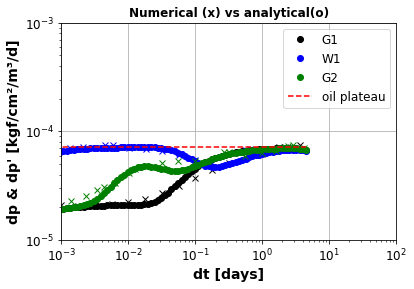

In [ ]:
plt.figure()
plt.loglog(df_t['G1'].values,df_der['G1'].values,'ko',label='G1')
plt.loglog(t_g1/24,der_g1/(q[0]*B[0]),'kx')
plt.loglog(df_t['W1'].values,df_der['W1'].values,'bo',label='W1')
plt.loglog(t_w1/24,der_w1/(q[1]*B[1]),'bx')
plt.loglog(df_t['G2'].values,df_der['G2'].values,'go',label='G2')
plt.loglog(t_g2/24,der_g2/(q[2]*B[2]),'gx')
plt.loglog(tbu/24,np.ones(len(ri))*o_p,'r--',label='oil plateau')
plt.ylim(1e-5, 1e-3)
plt.xlim(0.001, 100)
plt.xlabel("dt [days]")
plt.ylabel("dp & dp' [kgf/cm²/m³/d]")
plt.title('Numerical (x) vs analytical(o)')
plt.grid()
plt.legend()
plt.savefig('model_comp.png',dpi=200)    